# Rest - Time Serie EDA

https://towardsdatascience.com/time-series-problems-simply-explained-as-fast-food-combo-meals-70c6eb9bdef

# <span style='background :khaki' > Install & Importa Libraries </span>

In [6]:
### ***Enviroment Preparation***
# Install Pandas
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install lightgbm

!pip install sktime
!pip install sklego

#!pip install skforecast

# Update pip -- WARNING Resolution
!python.exe -m pip install --upgrade pip

In [7]:
### ***Imports***
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datetime import datetime
from datetime import timedelta

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller, kpss

import time
# Current Location.. !cd
#C:\Users\ghoyo\Desktop\TFM\Nuevo\Proyect

# Paths
data = r"C:\Users\ghoyo\Desktop\TFM 3.0\Project\GeneratedDfs\rests.json"

#### <span style="background:skyblue"> Load and Inspect Data <span>

In [8]:
df = pd.read_json(data)
df.shape

(11504, 4)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11504 entries, 2017-04-04 14:06:56 to 2022-11-24 22:04:22
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   delta_time           11504 non-null  int64
 1   rest_type            11504 non-null  int64
 2   total_time_listened  11504 non-null  int64
 3   n_streams_listened   11504 non-null  int64
dtypes: int64(4)
memory usage: 449.4 KB


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
delta_time,11504.0,14114.876043,18985.006531,601.0,2240.0,6107.0,19200.00,520748.0
rest_type,11504.0,1.896905,1.135508,0.0,1.0,2.0,3.00,6.0
total_time_listened,11504.0,1341.612483,1753.333871,12.0,331.0,810.0,1647.25,32331.0
n_streams_listened,11504.0,7.129781,8.876177,1.0,2.0,5.0,9.00,191.0


In [11]:
df.head(2)

,delta_time,rest_type,total_time_listened,n_streams_listened
2017-04-04 14:06:56,2041,1,217,2
2017-04-04 14:55:10,1530,1,1262,9


In [12]:
#TARGETS = df.columns  
Target = 'rest_type'

# <span style='background :khaki' > EDA </span>

### <span style="background:lightgreen"> Visualize Data <span>

#### <span style="background:skyblue"> Rest type Histogram <span>

<AxesSubplot: title={'center': 'Number of each rest type'}, ylabel='Frequency'>

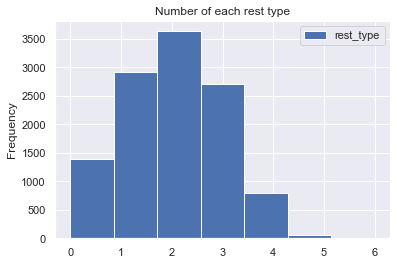

In [13]:
df[['rest_type']].plot.hist(bins = 7, title = 'Number of each rest type')

#### <span style="background:skyblue"> Correlation Matrix <span>

In [14]:
corr = df[['rest_type','n_streams_listened','delta_time','total_time_listened']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\ghoyo\AppData\Local\Temp\ipykernel_10668\3472659267.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,rest_type,n_streams_listened,delta_time,total_time_listened
rest_type,1.00,-0.01,0.80,-0.02
n_streams_listened,-0.01,1.00,-0.01,0.96
delta_time,0.80,-0.01,1.00,-0.01
total_time_listened,-0.02,0.96,-0.01,1.00


### <span style="background:lightgreen"> Average of rests done each day <span>

#### <span style="background:violet"> Functions <span>

In [15]:
def create_time_features(df, f=0):
    df = df.copy()
    if f == 0:
        df['year'] = df.index.year
        df['quarter'] = df.index.quarter
        df['month'] = df.index.month
        df['week'] = df.index.isocalendar().week
        df['day'] = df.index.day
        df['dayofyear'] = df.index.dayofyear
        df['dayofweek'] = df.index.dayofweek
    
        df['is_month_end'] = df.index.is_month_end
        df['is_month_start'] = df.index.is_month_start
        df['is_cuarter_end'] = df.index.is_quarter_end
        df['is_cuarter_start'] = df.index.is_quarter_start
        df['is_year_start'] = df.index.is_year_start
        df['date'] = df.index.date
    
    if f == 1:
        df['year'] = df.index.year
        df['quarter'] = df.index.quarter
        df['month'] = df.index.month
        df['week'] = df.index.isocalendar().week
        df['day'] = df.index.day
        df['dayofyear'] = df.index.dayofyear
        df['dayofweek'] = df.index.dayofweek
        
    if f == 2:
        df['day'] = df.index.day
        df['dayofyear'] = df.index.dayofyear
        
    return df

#### <span style="background:skyblue"> Analize by days <span>

In [16]:
df = create_time_features(df)

In [17]:
df.head(2)

,delta_time,rest_type,total_time_listened,n_streams_listened,year,quarter,month,week,day,dayofyear,dayofweek,is_month_end,is_month_start,is_cuarter_end,is_cuarter_start,is_year_start,date
2017-04-04 14:06:56,2041,1,217,2,2017,2,4,14,4,94,1,False,False,False,False,False,2017-04-04
2017-04-04 14:55:10,1530,1,1262,9,2017,2,4,14,4,94,1,False,False,False,False,False,2017-04-04


In [18]:
dates = pd.date_range(df.index[0].date(), df.index[-1].date())
date_list = dates.tolist()
len(date_list)

2061

#### <span style="background:skyblue"> Extract number of rests done each day <span>

In [19]:
n = []

for d in date_list:
    n.append(len(df[df['date'] == d]))
    
n

C:\Users\ghoyo\AppData\Local\Temp\ipykernel_10668\4013479390.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  n.append(len(df[df['date'] == d]))


[5,
 7,
 7,
 7,
 6,
 5,
 7,
 4,
 0,
 0,
 0,
 0,
 0,
 10,
 7,
 8,
 4,
 10,
 5,
 2,
 8,
 7,
 10,
 8,
 5,
 2,
 3,
 3,
 6,
 9,
 4,
 8,
 2,
 2,
 4,
 6,
 5,
 3,
 8,
 8,
 5,
 5,
 11,
 5,
 9,
 8,
 10,
 3,
 13,
 18,
 4,
 6,
 6,
 4,
 5,
 3,
 10,
 5,
 7,
 9,
 7,
 7,
 7,
 3,
 6,
 4,
 7,
 6,
 3,
 3,
 5,
 3,
 3,
 1,
 2,
 3,
 5,
 2,
 4,
 6,
 9,
 7,
 9,
 2,
 5,
 3,
 2,
 0,
 4,
 2,
 2,
 8,
 6,
 1,
 3,
 10,
 9,
 11,
 7,
 3,
 6,
 9,
 4,
 4,
 4,
 2,
 5,
 4,
 3,
 7,
 6,
 6,
 2,
 5,
 1,
 2,
 4,
 5,
 5,
 1,
 4,
 4,
 1,
 0,
 4,
 6,
 6,
 1,
 8,
 3,
 1,
 7,
 5,
 2,
 9,
 3,
 6,
 6,
 9,
 3,
 5,
 7,
 8,
 6,
 9,
 7,
 6,
 4,
 7,
 6,
 8,
 7,
 5,
 4,
 5,
 5,
 5,
 8,
 6,
 4,
 4,
 5,
 4,
 8,
 5,
 5,
 6,
 4,
 3,
 4,
 5,
 7,
 6,
 3,
 3,
 2,
 2,
 6,
 8,
 5,
 3,
 4,
 2,
 6,
 4,
 8,
 7,
 5,
 3,
 3,
 5,
 4,
 9,
 6,
 8,
 5,
 8,
 9,
 5,
 8,
 6,
 8,
 6,
 8,
 8,
 9,
 6,
 2,
 2,
 4,
 5,
 5,
 5,
 4,
 3,
 9,
 10,
 7,
 14,
 9,
 7,
 8,
 5,
 7,
 7,
 3,
 5,
 12,
 5,
 4,
 2,
 3,
 2,
 5,
 9,
 6,
 3,
 6,
 7,
 4,
 5,
 11,
 8,
 4,
 4,
 6,
 8

In [20]:
print(len(n))
print(np.mean(n))
round(np.mean(n),0)

2061
5.581756428918001


6.0

#### <span style="background:skyblue"> Create New Dataframe - Dayly Rests Number <span>

In [21]:
# Create Dataframe
base_df = pd.DataFrame()
base_df['n_rests'] = n
base_df['week_day'] = date_list
'''base_df['date'] = date_list
base_df['day'] = base_df['date'].apply(lambda x : x.day)
base_df['month'] = base_df['date'].apply(lambda x : x.month)'''

base_df['week_day'] = base_df['week_day'].apply(lambda x: x.weekday())
base_df.head(2)

,n_rests,week_day
0,5,1
1,7,2


In [22]:
Target = ['n_rests']

#### <span style="background:skyblue"> Características <span>

In [25]:
variance = 0
std = 0
var_coef = 0

# Calcular la varianza
variance = base_df[Target].var()

# Calcular la desviación estándar
std = base_df[Target].std()

# Calcular el coeficiente de variación (CV)
mean = base_df[Target].mean()
var_coef = std[-1]/ mean

In [26]:
print('variance:', variance)
print('std', std)
print('var_coef', var_coef)

variance: n_rests    7.997803
dtype: float64
std n_rests    2.828039
dtype: float64
var_coef n_rests    0.506657
dtype: float64


In [29]:
# Contar la cantidad de ceros y calcular la dispersión en cada columna
for col in base_df.columns:
    zero_count = (base_df[col] == 0).sum()
    sparsity = zero_count / len(base_df[col])
    print(f'{col}:')
    print(f'  Cantidad de ceros: {zero_count}')
    print(f'  Dispersión: {sparsity:.2f}')

n_rests:
  Cantidad de ceros: 28
  Dispersión: 0.01
week_day:
  Cantidad de ceros: 294
  Dispersión: 0.14


## <span style="background:khaki"> EDA <span>

#### <span style="background:skyblue"> Plot the data <span>

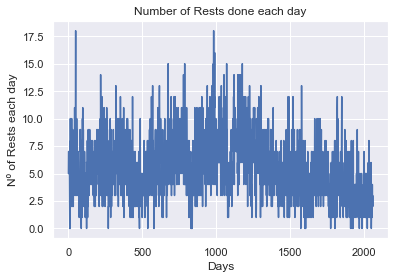

In [18]:
#Plot Number of Streams Listened Each Day
plt.xlabel('Days')
plt.ylabel('Nº of Rests each day')
plt.title("Number of Rests done each day")
plt.plot(base_df['n_rests'])

# <span style='background :khaki' > Study Stationarity </span>

#### <span style="background:skyblue"> Rolling Mean <span>

<span style="background:violet"> RM - Functions <span>

In [19]:
def analyze_stationarity(timeseries, title, df = base_df):
    fig, ax = plt.subplots(3, 1, figsize=(20, 12))

    rolmean = pd.Series(timeseries).rolling(window=30).mean() 
    rolstd = pd.Series(timeseries).rolling(window=30).std()
    ax[0].plot(timeseries, label= title)
    ax[0].plot(rolmean, label='rolling mean');
    ax[0].plot(rolstd, label='rolling std (x10)');
    ax[0].set_title('30-day window')
    ax[0].legend()
    
    rolmean = pd.Series(timeseries).rolling(window=270).mean() 
    rolstd = pd.Series(timeseries).rolling(window=270).std()
    ax[1].plot(timeseries, label= title)
    ax[1].plot(rolmean, label='rolling mean');
    ax[1].plot(rolstd, label='rolling std (x10)');
    ax[1].set_title('365-day window')
    ax[1].legend()
    
    x = range(0, len(df.index))
    rolmean = [np.mean(df.loc[:x, 'n_rests']) for x in df.index]
    rolstd = [np.std(df.loc[:x, 'n_rests']) for x in df.index]
    ax[2].plot(x, timeseries, label= title)
    ax[2].plot(rolmean, label='rolling mean');
    ax[2].plot(rolstd, label='rolling std (x10)');
    ax[2].set_title('increasing day window')
    ax[2].legend()
    
    plt.show()

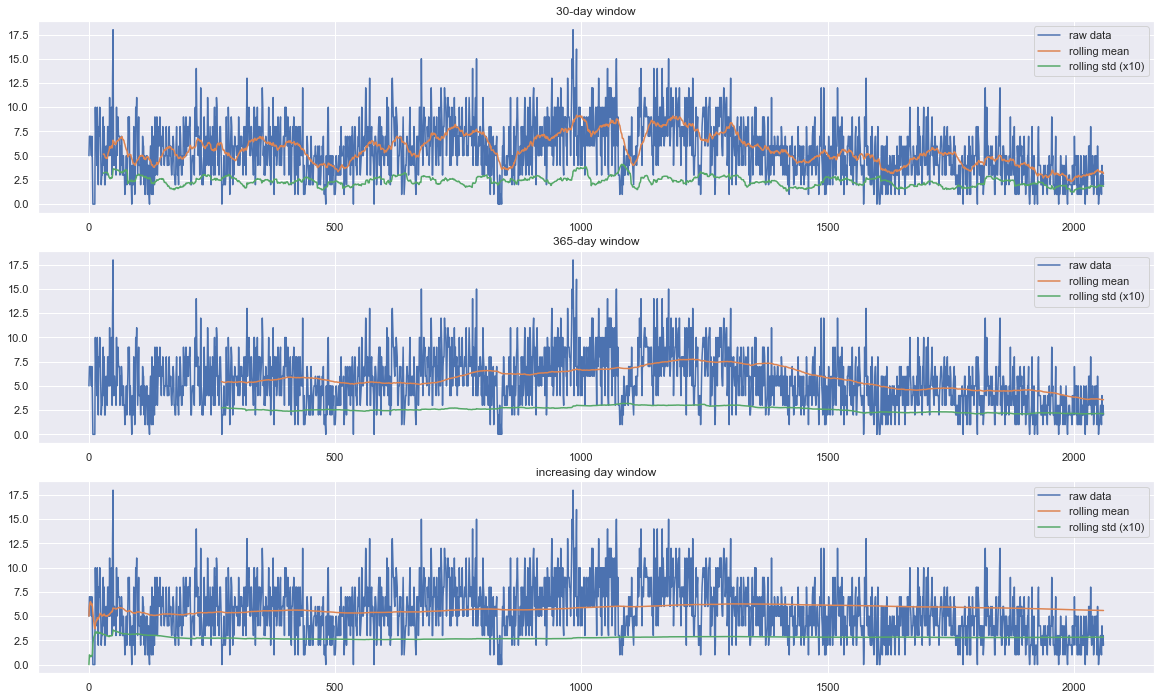

In [20]:
analyze_stationarity(base_df['n_rests'], 'raw data')

### <span style="background:lightgreen"> Time Serie Decomposition - ACF & PACF <span>

<span style="background:violet"> Decode - Functions <span>

In [21]:
def deco(df, share_type='n_rests', samples=2033, period=30):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(20,8))
    axs[0].set_ylabel('OBSERVED', fontsize=12)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_ylabel('TREND', fontsize=12)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=30 Month seasonality | Period=7 weekly seasonality.
    axs[2].set_ylabel('SEASONALITY', fontsize=12)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_ylabel('NOISE', fontsize=12)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

#### <span style="background:skyblue"> 200 Samples <span>

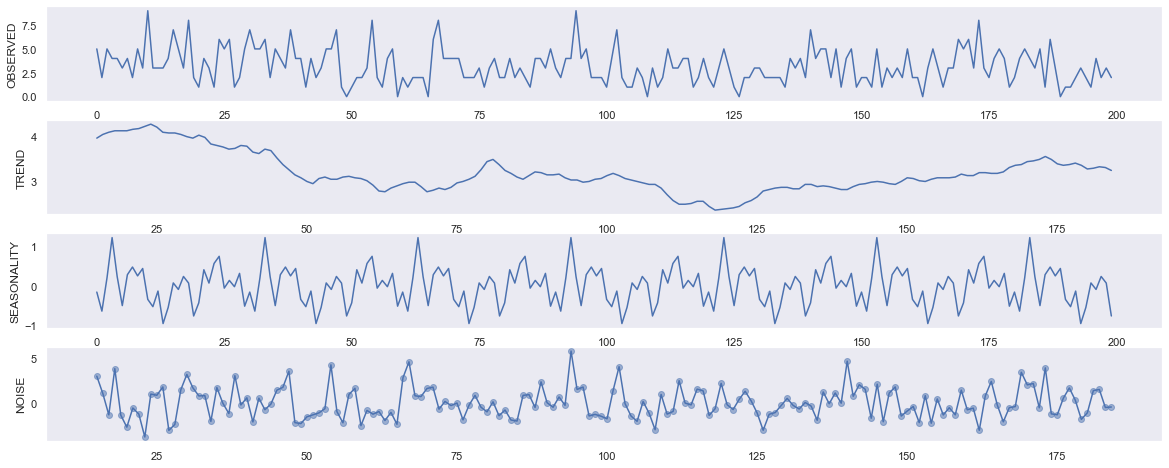

__________________________________________________________________________________________________________________________


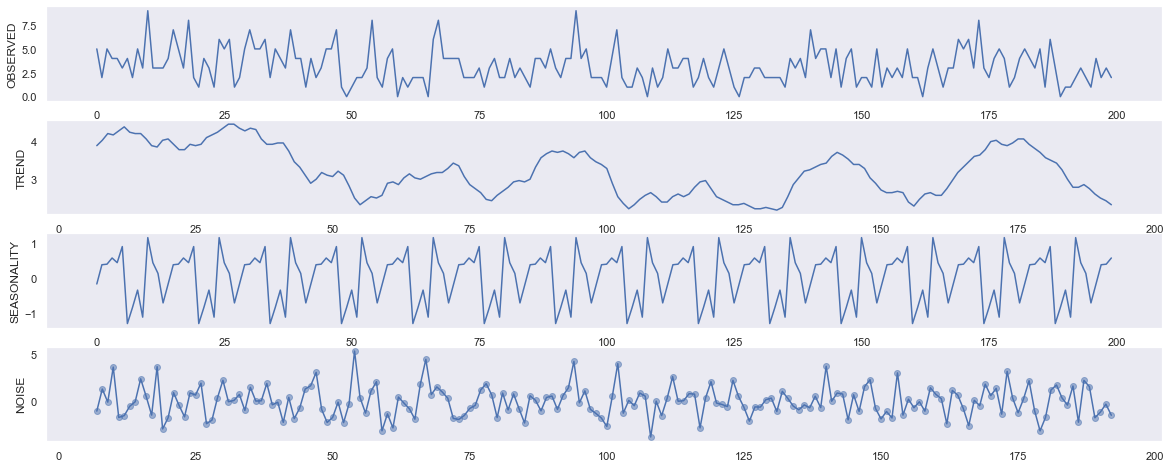

In [22]:
deco(base_df, samples = 200, period=30)
print('__________________________________________________________________________________________________________________________')
deco(base_df, samples = 200, period=14)

#### <span style="background:skyblue"> All Data  <span>

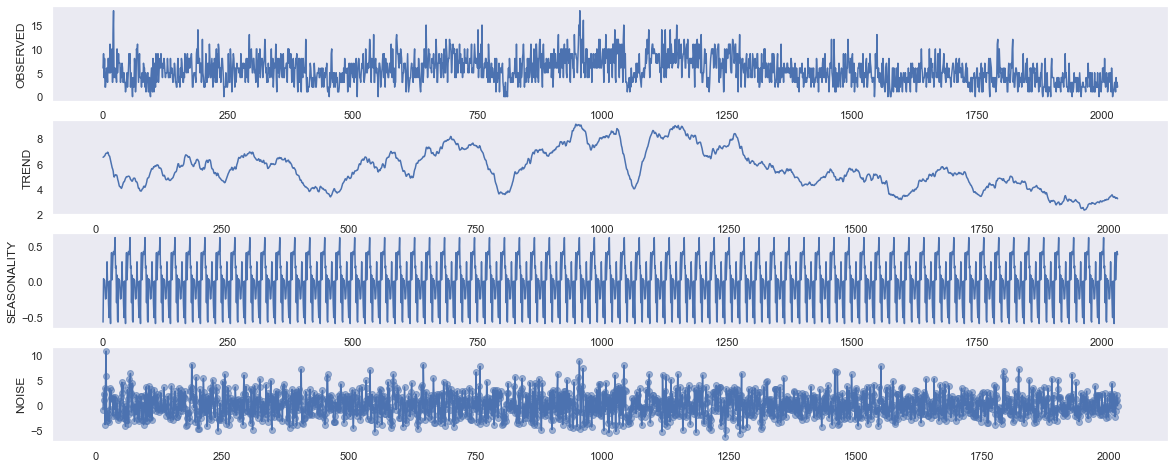

__________________________________________________________________________________________________________________________


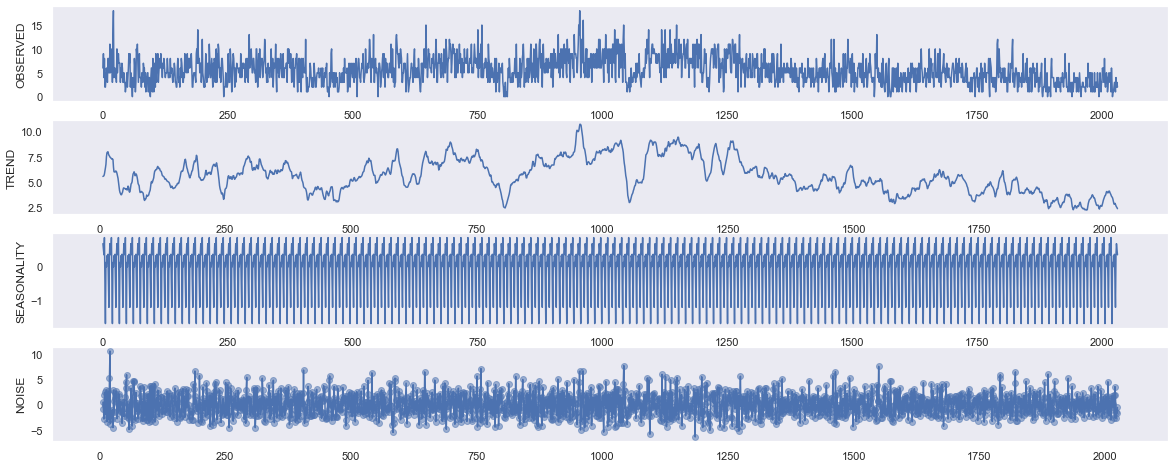

In [23]:
deco(base_df, period=30)
print('__________________________________________________________________________________________________________________________')
deco(base_df, period=14)

### <span style="background:lightgreen"> Autoregresiveness - ACF & PACF <span>

<span style="background:violet"> ACF -PCF - Functions <span>

In [24]:
# Plot Correlation
def plot_corrs(df = base_df, data = 'n_rests', l1 = 30, l2 = 14):
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    plot_acf(df[data].values, lags=l1, ax=ax[0], title='Autocorr '+ data + ' ' + str(l1))
    plot_pacf(df[data].values, lags=l1, ax=ax[1], title='Partialcorr '+ data + ' ' + str(l1))
    #plot_acf(df[data].values, lags=l2, ax=ax[1][0], title='Autocorr '+ data + ' ' + str(l2))
    #plot_pacf(df[data].values, lags=l2, ax=ax[1][1], title='Partialcorr '+ data + ' ' + str(l2))

    plt.show()

In [25]:
def plot_dailies(df = base_df, data = 'n_rests'):
    fig, ax = plt.subplots(7,2,figsize=(20,20))

    plot_acf(df.loc[df['week_day'] == 0, data].values, ax=ax[0][0], title='Autocorrelation - Day 0 - ' + str(data))
    plot_pacf(df.loc[df['week_day'] == 0, data].values, ax=ax[0][1], title='Partial Autocorrelation - Day 0 - ' + str(data))

    plot_acf(df.loc[df['week_day'] == 1, data].values, ax=ax[1][0], title='Autocorrelation - Day 1 - ' + str(data))
    plot_pacf(df.loc[df['week_day'] == 1, data].values, ax=ax[1][1], title='Partial Autocorrelation - Day 1 - ' + str(data))

    plot_acf(df.loc[df['week_day'] == 2, data].values, ax=ax[2][0], title='Autocorrelation - Day 2 - ' + str(data))
    plot_pacf(df.loc[df['week_day'] == 2, data].values, ax=ax[2][1], title='Partial Autocorrelation - Day 2 - ' + str(data))

    plot_acf(df.loc[df['week_day'] == 3, data].values, ax=ax[3][0], title='Autocorrelation - Day 3 - ' + str(data))
    plot_pacf(df.loc[df['week_day'] == 3, data].values, ax=ax[3][1], title='Partial Autocorrelation - Day 3 - ' + str(data))

    plot_acf(df.loc[df['week_day'] == 4, data].values, ax=ax[4][0], title='Autocorrelation - Day 4 - ' + str(data))
    plot_pacf(df.loc[df['week_day'] == 4, data].values, ax=ax[4][1], title='Partial Autocorrelation - Day 4 - ' + str(data))

    plot_acf(df.loc[df['week_day'] == 5, data].values, ax=ax[5][0], title='Autocorrelation - Day 5 - ' + str(data))
    plot_pacf(df.loc[df['week_day'] == 5, data].values, ax=ax[5][1], title='Partial Autocorrelation - Day 5 - ' + str(data))

    plot_acf(df.loc[df['week_day'] == 6, data].values, ax=ax[6][0], title='Autocorrelation - Day 6 - ' + str(data))
    plot_pacf(df.loc[df['week_day'] == 6, data].values, ax=ax[6][1], title='Partial Autocorrelation - Day 6 - ' + str(data))
    plt.show()

#### <span style="background:skyblue"> ACF & PACF <span>

C:\Users\ghoyo\miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


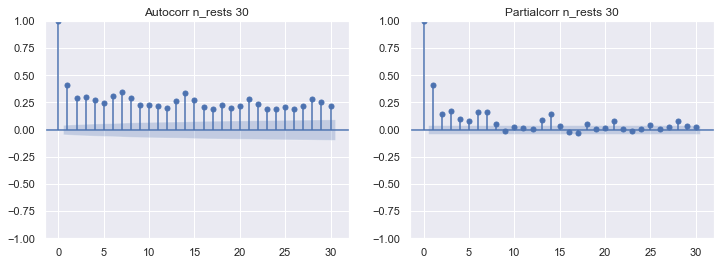

In [26]:
plot_corrs()

#### <span style='background :yellow' > Conclusiones Autocorrelacion Alta??? -- o AutocorrParcial Alta??? </span>

<span style='background :yellow' > Que signignifican estos valores altos y como se puede proceder </span>

<span style='background :yellow' > Como no hay ningun bucle subida bajada, intuímos que no son AUTOREGRESIVOS???? Habria que estudiarlo por horas, es decir un dia se explica por el anterior, como un servicio de alquiler de bicis electricas, que se usan mas a unas horas que a otras. Esto también depende fuertemente del usuario</span>

https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/

https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/

#### <span style="background:skyblue"> ACF & PACF - By Week Day <span>

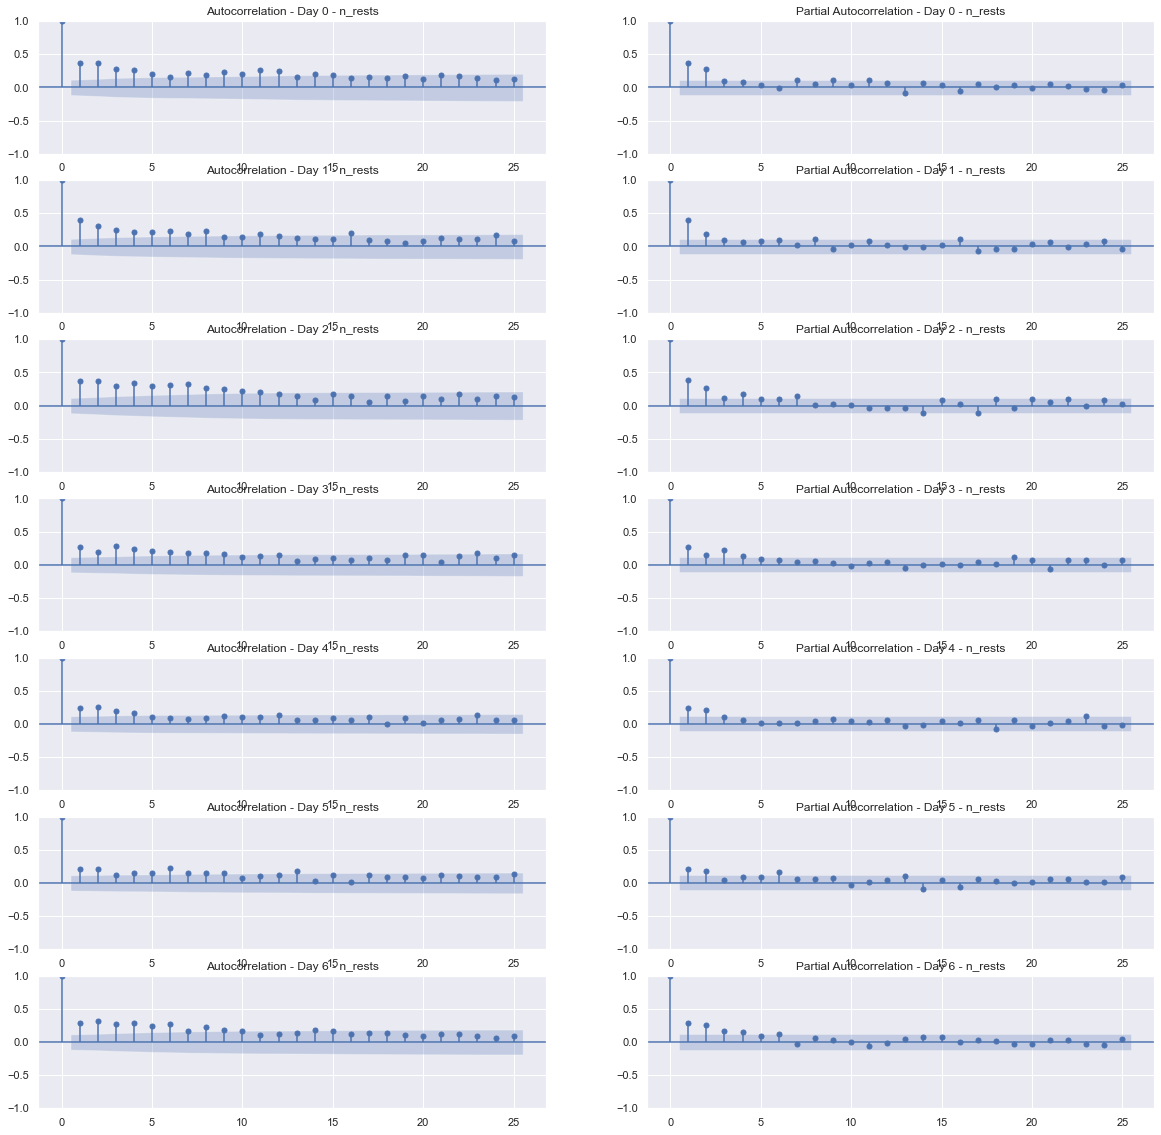

In [27]:
plot_dailies()

In [28]:
#base_df.drop('week_day', inplace=True, axis=1)

##### It is clearly visible there is no corralation between same dayweeks
- Maybe between hours we can find that correlation in same dayweeks, but between days and the small duration of streams 


### <span style="background:lightgreen"> TESTS <span>

https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

<span style="background:violet"> Test - Functions <span>

In [29]:
#define function for ADF test
def adf_test(timeseries, i, c = 1):
    """
    Perform augmented Dickey-Fuller test and print the results
    """
    if(c == 1):
        print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    if(c == 1):
        print (dfoutput)
    
    if(dftest[1] < 0.05):
        if(c == 1):
            print('\n', i, '-- is STATIONARY')
        return 0
    
    else:
        if(c == 1):
            print('\n', i, 'is NOT Stationary')
        return 1

In [30]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries, i, c=1):
    """
    Perform augmented KPSS test and print the results
    """
    
    if c == 1:
        print(f"Results of KPSS Test: -- {i}")
    
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    
    for key, value in kpsstest[3].items():
        kpss_output[f'Critical Value ({key})'] = value
    
    if kpsstest[1] < 0.05:
        result = 0
        message = "-- is STATIONARY"
    else:
        result = 1
        message = "is NOT Stationary"
    
    if c == 1:
        print(kpss_output)
        print(f"\n{i} {message}")
    
    return result
    

#### <span style="background:skyblue"> Dickey-Fuller <span>

In [31]:
#### Dickey Fuller
    # Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
    # Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
        # p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

    # p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    # p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
    
    # ADF Statistic < %Percetnajes -- Confidence Rechanzando

In [32]:
fuller_station = []
fuller_station.append(adf_test(base_df['n_rests'], 'n_rests', c = 0))
print(fuller_station)

[0]


#### <span style="background:skyblue"> KPSS <span>

In [33]:
kpss_station = []
kpss_station.append(kpss_test(base_df['n_rests'], 'n_rests', c = 0))
print(kpss_station)

[0]


C:\Users\ghoyo\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### <span style='background :yellow' > Make Serie Stationary: </span>
- Serveral Ways

3. Types of Stationarity
Let us understand the different types of stationarities and how to interpret the results of the above tests.

- Strict Stationary: A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are not the function of time. The aim is to convert a non-stationary series into a strict stationary series for making predictions.

- Trend Stationary: A series that has no unit root but exhibits a trend is referred to as a trend stationary series. Once the trend is removed, the resulting series will be strict stationary. The KPSS test classifies a series as stationary on the absence of unit root. This means that the series can be strict stationary or trend stationary.

- Difference Stationary: A time series that can be made strict stationary by differencing falls under difference stationary. ADF test is also known as a difference stationarity test.

4. Posible Cases:

- Case 1: Both tests conclude that the series is not stationary -> series is not stationary
- Case 2: Both tests conclude that the series is stationary -> series is stationary
- Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary
- Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

### <span style="background:lightgreen"> Transform serie to Stationey <span>

<span style="background:violet"> Stationary Transform - Functions <span>

In [34]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [35]:
def run_stationary_test(TARGETS, df):
    fuller_station = []
    kpss_station = []
    fuller_station.append(adf_test(df['n_rests'], 'n_rests', 0))
    kpss_station.append(kpss_test(df['n_rests'], 'n_rests', 0))
    
    return fuller_station, kpss_station

In [36]:
def cases(kp = kpss_station, fl = fuller_station, TS = Target):
    station = []
    
    for k,f,i in zip(kp, fl, TS):
        if (k == 1 and f == 1):
            #print(i, '-- Case 1: Not Stationary\n')
            station.append(1)
        
        elif(k == 0 and f == 0):
            #print(i, '-- Case 2: Stationary\n')
            station.append(2)
        
        elif(k == 0 and f == 1):
            #print(i, '-- Case 3: Trend Stationary -- Remove Trend for Strict Statinary Serie\n')
            station.append(3)
    
        elif(k == 1 and f == 0):
            #print(i, '-- Case 4: Difference Stationary -- Use differencing to make serie Stationary\n')
            station.append(4)
        
        else:
            print('ERROR')
        
    return station

In [37]:
# In this method, we compute the difference of consecutive terms in the series. 
# Differencing is typically performed to get rid of the varying mean. Mathematically, 
# differencing can be written as:
def differencing(df, i):
    df[i + '_diff'] = df[i] - df[i].shift(1)
    #df[i + '_diff'].dropna().plot(figsize=(12, 8))
    
# In seasonal differencing, instead of calculating the difference between consecutive values, 
# we calculate the difference between an observation and a previous observation from the same season. 
# For example, an observation taken on a Monday will be subtracted from an observation taken on the previous Monday. 
def seasonal_diff(df, i, time = 'd'):
    if time == 'd':
        n=7
    
    elif time == 'h':
        n=24
        
    else:
        print('ERROR')
        return 0
        
    df[i + '_season_diff'] = df[i] - df[i].shift(n)
    
# Transformations are used to stabilize the non-constant variance of a series. 
# Common transformation methods include power transform, square root, and log transform. 
# Let’s do a quick log transform and differencing on our air passenger dataset:
def transformation(df, i):
    df[i + '_log'] = np.log(df[i])
    df[i + '_log_diff'] = df[i + '_log'] - df[i + '_log'].shift(1)
    df[i + '_log_diff'].dropna(inplace = True)
    #train[i + '_log_diff'].dropna()

In [38]:
def to_stationary(station, TARGETS):
    for s,i in zip(station, TARGETS):
        if s == 1:
            #print(i + '-- No Stationary -- Transformation\n')
            transformation(df, i)
        
        elif s == 2:
            #print(i + '-- Stationary -- Continue\n')
            pass
        
        elif s == 3:
            #print(i, '-- Trend Stationary -- Remove Trend for Strict Statinary\n')
            seasonal_diff(df, i , 'd')
        
        elif s == 4:
            #print(i, '-- Difference Stationary -- Use differencing to make serie Stationary\n')
            differencing(df, i)
        
        else:
            print('ERROR')
            return -1

    #print(station)
    df.dropna(inplace=True)
    df.head()
    
    return 0

In [39]:
def modify_Targets(st, TS = TARGET, df = df, no_ts = [], c = 0):
    counter = c
    nt = no_ts.copy()
    TAGS = list(df.columns)
    
    #print('df TAGS -- ', TAGS)
    #print('\n Actual TAGS -- ', TS)
    #print('\t\t\tmodify - target - st = ', st)
    
    for s,i in zip(st, range(len(st))):
        if s != 2:
            nt.append(TS[i])
            counter = counter + 1
            
    #print('\n Remove from df TAGS -- ', nt)
    
    for n in nt:
        TAGS.remove(n)
        
    #print('\n New TAGS --', TAGS)
        
    return TAGS, nt, counter

NameError: name 'TARGET' is not defined

In [ ]:
# Generated Info
i = 0
counter = 0
lp = 3
aux = 1

nt = []
station = []
fuller_station = []
kpss_station = []
tags = []

In [ ]:
def recursive_station(nt, count, i, loop_condition = aux, df = base_df, targets = 'n_rests'):
    warnings.simplefilter('ignore')
    print('Original Targets nº', i, targets)
    
    fuller_station, kpss_station = run_stationary_test(targets, df)
    print('fuller result = ', fuller_station)
    print('kpss result = ', kpss_station)
    
    # def cases(kp = kpss_station, fl = fuller_station, TS = TARGETS):
    station = cases(kp = kpss_station, fl = fuller_station, TS = targets).copy()
    print('Cases Station = ', station) # Station = [1,2,2,3,3,4,4]
    
    # If Station = [2,2,2,2,2,2] -- All 2. RETURN / END
    if(sum(station) == len(station)*2):
        print('All Stationary')
        if(count == 0):
            return i
        return tags.copy()
    
    # ELSE
    to_stationary(station, targets)
    tags, nt, counter = modify_Targets(st = station, TS = targets, df = df, no_ts = nt, c = count)
    
    print('\nc = ', count)
    print('nt = ', nt)
    print('df.colums = ', list(df.columns))
    print('tags = ', tags)
    print('targets = ', targets)
    #fuller_station, kpss_station = run_stationary_test(tags, df)
    
    if(loop_condition == lp):
        print('\n______________________________Ended Manualy______________________________\n')
        print('tags', tags)
        return tags
    
    elif(sum(fuller_station) >=1 or sum(kpss_station)>= 1):
        print('----------------------- iteration number º ', i, ' ------------------------------')
        i = i+1
        
        print('TARGETS = ', targets)
        print('____________________________________________________________________________________________________')
        print('____________________________________________________________________________________________________\n')
        
        loop_condition = loop_condition + 1
        tags = recursive_station(df, tags, nt, count, i, loop_condition)
        
    else:
        return tags
    
    return tags

In [ ]:
def clean_targets(df, tags):
    df = df[tags]
    return df

#### <span style="background:skyblue"> Make It Work <span>

In [ ]:
ts = recursive_station(df = base_df, targets = 'n_rests', nt=nt, count = counter, i = 'n_rests')
print('____________________________ TARGETS -- \n', ts, '\n')

In [ ]:
ts

In [ ]:
print(base_df.head(1))
base_df = clean_targets(base_df, ts)
base_df.head(1)

https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322

# <span style='background :khaki' > Save </span>

In [ ]:
base_df = base_df.to_frame()
base_df.head(2)

In [ ]:
base_df.index = date_list
base_df.head(2)

In [ ]:
# Rest Types DF
base_df.to_json(r"C:\Users\ghoyo\Desktop\TFM4\Project\GeneratedDfs\dayly_rests.json")

In [ ]:
# Calcular la varianza
variance = base_df['n_rests'].var()
    
# Calcular la desviación estándar
std = base_df['n_rests'].std()

# Calcular el coeficiente de variación (CV)
mean = base_df['n_rests'].mean()
var_coef = std/ mean
    
print('variance:', variance)
print('std', std)
print('var_coef', var_coef)

In [ ]:
# Contar la cantidad de ceros y calcular la dispersión en cada columna
zero_count = (base_df['n_rests'] == 0).sum()
sparsity = zero_count / len(base_df['n_rests'])
print('n_rests')
print(f'  Cantidad de ceros: {zero_count}')
print(f'  Dispersión: {sparsity:.2f}')